In [3]:
import random
from dataclasses import dataclass
import fractions
import music21
from music21 import midi, pitch
import copy
import matplotlib.pyplot as plt 
import numpy as np

In [4]:
# @dataclass(frozen=True)
# class MelodyData:
#     """
#     A data class representing the data of a melody.

#     This class encapsulates the details of a melody including its notes, total
#     duration, and the number of bars. The notes are represented as a list of
#     tuples, with each tuple containing a pitch and its duration. The total
#     duration and the number of bars are computed based on the notes provided.

#     Attributes:
#         notes (list of tuples): List of tuples representing the melody's notes.
#             Each tuple is in the format (pitch, duration).
#         duration (int): Total duration of the melody, computed from notes.
#         number_of_bars (int): Total number of bars in the melody, computed from
#             the duration assuming a 4/4 time signature.

#     Methods:
#         __post_init__: A method called after the data class initialization to
#             calculate and set the duration and number of bars based on the
#             provided notes.
#     """

#     notes: list
#     duration: int = None  # Computed attribute
#     number_of_bars: int = None  # Computed attribute

#     def __post_init__(self):
#         object.__setattr__(
#             self, "duration", sum(duration for _, duration in self.notes)
#         )
#         object.__setattr__(self, "number_of_bars", int(self.duration // 2))


#example with all in it 

class MelodyData:
    """
    A data class representing the data of a melody.

    Attributes:
        notes (list of tuples): List of tuples representing the melody's notes.
        duration (int): Total duration of the melody, computed from notes.
        number_of_bars (int): Total number of bars in the melody.
        time_signature (music21.meter.TimeSignature): Time signature of the melody.
        scale (str): The scale of the melody.

    Methods:
        __post_init__: Calculates and sets the duration and number of bars.
        load_from_midi: Loads melody data from a MIDI file.
    """

    def __init__(self, file_path=None):
        self.notes: list = []
        self.duration: float = 0
        self.number_of_bars: int = 0
        self.time_signature: music21.meter.TimeSignature = None
        self.midi_data: music21.stream.Score  = None
        self.key = None
        self.tempo: music21.tempo.MetronomeMark=None
        self.durations_array:np.ndarray =[]
        self.ventana = 6  # Tamaño de la ventana para la mediana móvil
        self.alegro_points=[]
        #musical info
        self.chord_mappings_index = {
            "I": [0,4,7],
            "ii": [2,5,9],
            "iii": [4,7,11],
            "IV": [5,9,0],
            "V": [7,11,2],
            "vi": [9, 0, 4],
            "vii-dim": [11, 2, 5]
        }
        self.chord_names=list(self.chord_mappings_index.keys())
        self.chord_mappings={}
        self.escala_cromatica = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"] 
        self.our_escala = []
        self.note_measure_correspondance=[]
        self.mapeo_bemoles = {
            "Db": "C#",
            "Eb": "D#",
            "Fb": "E",  # Fb es en realidad E
            "Gb": "F#",
            "Ab": "G#",
            "Bb": "A#",
            "Cb": "B"   # Cb es en realidad B
            }

        if file_path:
            self.load_from_midi(file_path)



    def __post_init__(self):
        self.duration = sum(duration for _, duration, _ in self.notes)
        if self.time_signature:
            self.number_of_bars = int(self.duration / (self.time_signature.numerator ))
    def mediana_movil(self,arr):
        # La longitud de la mediana móvil será menor que la del array original
        # debido a los bordes donde la ventana no se ajusta completamente.
        num_elementos = len(arr) - self.ventana + 1
        mediana_movil = np.zeros(len(arr))

        for i in range(num_elementos):
            mediana_movil[i] = np.median(arr[i:(i+self.ventana)])

        return mediana_movil
    
    @staticmethod
    def gaussian(x, mu, sig):
        return (
            1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
        )

    def load_from_midi(self, file_path):

        #populate class
        self.midi_data = music21.converter.parse(file_path)
        self.time_signature = self.midi_data.recurse().getElementsByClass('TimeSignature')[0]
        # self.key = self.midi_data.analyze('key') #esto será para sacarlo analizandolo no la Key Signature
        try:
            self.key = self.midi_data.flat.getElementsByClass(music21.key.Key)[0]
        except:
            self.key = self.midi_data.flat.getElementsByClass(music21.key.KeySignature)[0].asKey()

        self.tempo=self.midi_data.recurse().getElementsByClass(music21.tempo.MetronomeMark)[0]

        #retrive melody
        parts = [part.flat for part in self.midi_data.parts]
        for n in parts[0]:
            try:
                if n.isNote:
                    nombre_nota = n.pitch.name
                    octava= n.pitch.octave
                    if nombre_nota in self.mapeo_bemoles.keys():
                        nombre_nota=self.mapeo_bemoles[nombre_nota]
                    duracion = n.duration.quarterLength
                elif n.isRest:
                    nombre_nota = "Rest"
                    octava= 5
                    duracion = n.duration.quarterLength
                elif n.isChord:
                    nombre_nota = [i.pitch.name for i in n.notes]
                    octava= [i.pitch.octave for i in n.notes]
                    if any([i in self.mapeo_bemoles.keys() for i in nombre_nota]):
                        nombre_nota=[self.mapeo_bemoles[i] for i in nombre_nota]
                    octava=octava[0]
                    nombre_nota=nombre_nota[0]#esto es algo temporal para evitar tener problemas con las listas
                    duracion = n.notes[0].duration.quarterLength#[i.duration.quarterLength for i in nota.notes]
                else:
                    print(f"error con {n}")
                    continue

                if isinstance(duracion,fractions.Fraction):
                    duracion=float(duracion)
                self.note_measure_correspondance.append(n.measureNumber)

                note_repr = (nombre_nota, duracion,octava)
                self.notes.append(note_repr)
                aux_duration= duracion#-1* duracion if n.isRest else duracion
                self.durations_array.append(aux_duration)
            except:
                print(f"error con {n}")
        if self.durations_array:        
            self.durations_array=np.array(self.durations_array)

        # Restar uno a cada elemento de la lista
        self.note_measure_correspondance = [x - 1 for x in self.note_measure_correspondance]

        # Crear un diccionario para agrupar las posiciones
        aux_note_measure_correspondance_diccionario = {}
        for idx, valor in enumerate(self.note_measure_correspondance):
            if valor in aux_note_measure_correspondance_diccionario:
                aux_note_measure_correspondance_diccionario[valor].append(idx)
            else:
                aux_note_measure_correspondance_diccionario[valor] = [idx]

        self.note_measure_correspondance=aux_note_measure_correspondance_diccionario

        # Ejemplo de uso
        self.alegro_points = self.mediana_movil(self.durations_array)
        #algunos puntos son 0 porque la mediana al final no tenemos elementos para calcularla.
        #calculamos la media de el resto y asignamos unos pesos probabilisticos para elegir segun esta diferencia, la probabilidad de añadir un parte rapida
        #media_aux=self.alegro_points[self.alegro_points!=0].mean()
        bool_small_duration=np.where(self.durations_array<self.alegro_points[self.alegro_points!=0].mean(),1,0)
        gaus_aux=self.gaussian(np.linspace(-2,2,self.alegro_points.size),0,1)
        self.positions_allegro=[]
        for i in np.arange(self.alegro_points.size):
            if random.random()<gaus_aux[i]:
                if bool_small_duration[i]>0:
                    self.positions_allegro.append(i)
        
        # scale data
        #len_escala=len(self.escala_cromatica)
        nota_tonica = self.key.tonicPitchNameWithCase
        pos_0 = self.escala_cromatica.index(nota_tonica)
        self.our_escala=self.escala_cromatica[pos_0:]+self.escala_cromatica[:pos_0]
        for i_key,i_value in self.chord_mappings_index.items():
            self.chord_mappings[i_key]=[self.our_escala[i] for i in i_value]  
            
        # if n.isNote:
        #     note_repr = (n.pitch.midi, n.duration.quarterLength)
        #     self.notes.append(note_repr)
        # elif n.isRest:
        #     rest_repr = ('rest', n.duration.quarterLength)
        #     self.notes.append(rest_repr)

        self.__post_init__()

    # def midi_note_to_name_dur(self, note):
    #     if note.isNote:
    #         return (note.pitch.midi, note.duration.quarterLength)
    #     elif note.isRest:
    #         return ('rest', note.duration.quarterLength)
    #     return None



class GeneticMelodyHarmonizer:
    """
    Generates chord accompaniments for a given melody using a genetic algorithm.
    It evolves a population of chord sequences to find one that best fits the
    melody based on a fitness function.

    Attributes:
        melody_data (MusicData): Data containing melody information.
        chords (list): Available chords for generating sequences.
        population_size (int): Size of the chord sequence population.
        mutation_rate (float): Probability of mutation in the genetic algorithm.
        fitness_evaluator (FitnessEvaluator): Instance used to assess fitness.
    """

    def __init__(
        self,
        melody_data,
        population_size,
        mutation_rate,
        fitness_evaluator,
    ):
        """
        Initializes the generator with melody data, chords, population size,
        mutation rate, and a fitness evaluator.

        Parameters:
            melody_data (MusicData): Melody information.
            chords (list): Available chords.
            population_size (int): Size of population in the algorithm.
            mutation_rate (float): Mutation probability per chord.
            fitness_evaluator (FitnessEvaluator): Evaluator for chord fitness.
        """
        self.melody_data = melody_data
        self.mutation_rate = mutation_rate
        self.population_size = int(population_size)
        self.fitness_evaluator = fitness_evaluator
        self._population = []

    def generate(self, generations=1000):
        """
        Generates a chord sequence that harmonizes a melody using a genetic
        algorithm.

        Parameters:
            generations (int): Number of generations for evolution.

        Returns:
            best_chord_sequence (list): Harmonization with the highest fitness
                found in the last generation.
        """
        self._population = self._initialise_population()
        for _ in range(generations):
            parents = self._select_parents()
            new_population = self._create_new_population(parents)
            self._population = new_population
        best_chord_sequence = (
            self.fitness_evaluator.get_chord_sequence_with_highest_fitness(
                self._population
            )
        )
        return best_chord_sequence

    def _initialise_population(self):
        """
        Initializes population with random chord sequences.

        Returns:
            list: List of randomly generated chord sequences.
        """
        return [
            self._generate_random_chord_sequence()
            for _ in range(self.population_size)
        ]

    def _generate_random_chord_sequence(self):
        """
        Generate a random chord sequence with as many chords as the numbers
        of bars in the melody.

        Returns:
            list: List of randomly generated chords.
        """
        return [
            random.choice(self.melody_data.chord_names)
            for _ in range(self.melody_data.number_of_bars)
        ]

    def _select_parents(self):
        """
        Selects parent sequences for breeding based on fitness.

        Returns:
            list: Selected parent chord sequences.
        """
        fitness_values = [
            self.fitness_evaluator.evaluate(seq) for seq in self._population
        ]
        return random.choices(
            self._population, weights=fitness_values, k=self.population_size
        )

    def _create_new_population(self, parents):
        """
        Generates a new population of chord sequences from the provided parents.

        This method creates a new generation of chord sequences using crossover
        and mutation operations. For each pair of parent chord sequences,
        it generates two children. Each child is the result of a crossover
        operation between the pair of parents, followed by a potential
        mutation. The new population is formed by collecting all these
        children.

        The method ensures that the new population size is equal to the
        predefined population size of the generator. It processes parents in
        pairs, and for each pair, two children are generated.

        Parameters:
            parents (list): A list of parent chord sequences from which to
                generate the new population.

        Returns:
            list: A new population of chord sequences, generated from the
                parents.

        Note:
            This method assumes an even population size and that the number of
            parents is equal to the predefined population size.
        """
        new_population = []
        for i in range(0, self.population_size, 2):
            child1, child2 = self._crossover(
                parents[i], parents[i + 1]
            ), self._crossover(parents[i + 1], parents[i])
            child1 = self._mutate(child1)
            child2 = self._mutate(child2)
            new_population.extend([child1, child2])
        return new_population

    def _crossover(self, parent1, parent2):
        """
        Combines two parent sequences into a new child sequence using one-point
        crossover.

        Parameters:
            parent1 (list): First parent chord sequence.
            parent2 (list): Second parent chord sequence.

        Returns:
            list: Resulting child chord sequence.
        """
        cut_index = random.randint(1, len(parent1) - 1)
        return parent1[:cut_index] + parent2[cut_index:]

    def _mutate(self, chord_sequence):
        """
        Mutates a chord in the sequence based on mutation rate.

        Parameters:
            chord_sequence (list): Chord sequence to mutate.

        Returns:
            list: Mutated chord sequence.
        """
        if random.random() < self.mutation_rate:
            mutation_index = random.randint(0, len(chord_sequence) - 1)
            chord_sequence[mutation_index] = random.choice(self.melody_data.chord_names)
        return chord_sequence
    

class FitnessEvaluator:
    """
    Evaluates the fitness of a chord sequence based on various musical criteria.

    Attributes:
        melody (list): List of tuples representing notes as (pitch, duration).
        chords (dict): Dictionary of chords with their corresponding notes.
        weights (dict): Weights for different fitness evaluation functions.
        preferred_transitions (dict): Preferred chord transitions.
    """

    def __init__(
        self, melody_data, weights, preferred_transitions):
        """
        Initialize the FitnessEvaluator with melody, chords, weights, and
        preferred transitions.

        Parameters:
            melody_data (MelodyData): Melody information.
            chord_mappings (dict): Available chords mapped to their notes.
            weights (dict): Weights for each fitness evaluation function.
            preferred_transitions (dict): Preferred chord transitions.
        """
        self.melody_data = melody_data
        self.chord_mappings = melody_data.chord_mappings
        self.weights = weights
        self.preferred_transitions = preferred_transitions

    def get_chord_sequence_with_highest_fitness(self, chord_sequences):
        """
        Returns the chord sequence with the highest fitness score.

        Parameters:
            chord_sequences (list): List of chord sequences to evaluate.

        Returns:
            list: Chord sequence with the highest fitness score.
        """
        return max(chord_sequences, key=self.evaluate)

    def evaluate(self, chord_sequence):
        """
        Evaluate the fitness of a given chord sequence.

        Parameters:
            chord_sequence (list): The chord sequence to evaluate.

        Returns:
            float: The overall fitness score of the chord sequence.
        """
        return sum(
            self.weights[func] * getattr(self, f"_{func}")(chord_sequence)
            for func in self.weights
        )

    def _chord_melody_congruence(self, chord_sequence):
        """
        Calculates the congruence between the chord sequence and the melody.
        This function assesses how well each chord in the sequence aligns
        with the corresponding segment of the melody. The alignment is
        measured by checking if the notes in the melody are present in the
        chords being played at the same time, rewarding sequences where the
        melody notes fit well with the chords.

        Parameters:
            chord_sequence (list): A list of chords to be evaluated against the
                melody.

        Returns:
            float: A score representing the degree of congruence between the
                chord sequence and the melody, normalized by the melody's
                duration.
        """
        score, melody_index = 0, 0
        for chord in chord_sequence:
            bar_duration = 0
            while bar_duration < 2 and melody_index < len(
                self.melody_data.notes
            ):
                pitch, duration, _ = self.melody_data.notes[melody_index]
                if pitch[0] in self.chord_mappings[chord]:
                    score += duration
                bar_duration += duration
                melody_index += 1
        return score / self.melody_data.duration

    def _chord_variety(self, chord_sequence):
        """
        Evaluates the diversity of chords used in the sequence. This function
        calculates a score based on the number of unique chords present in the
        sequence compared to the total available chords. Higher variety in the
        chord sequence results in a higher score, promoting musical
        complexity and interest.

        Parameters:
            chord_sequence (list): The chord sequence to evaluate.

        Returns:
            float: A normalized score representing the variety of chords in the
                sequence relative to the total number of available chords.
        """
        unique_chords = len(set(chord_sequence))
        total_chords = len(self.chord_mappings)
        return unique_chords / total_chords

    def _harmonic_flow(self, chord_sequence):
        """
        Assesses the harmonic flow of the chord sequence by examining the
        transitions between successive chords. This function scores the
        sequence based on how frequently the chord transitions align with
        predefined preferred transitions. Smooth and musically pleasant
        transitions result in a higher score.

        Parameters:
            chord_sequence (list): The chord sequence to evaluate.

        Returns:
            float: A normalized score based on the frequency of preferred chord
                transitions in the sequence.
        """
        score = 0
        for i in range(len(chord_sequence) - 1):
            next_chord = chord_sequence[i + 1]
            if next_chord in self.preferred_transitions[chord_sequence[i]]:
                score += 1
        return score / (len(chord_sequence) - 1)

    def _functional_harmony(self, chord_sequence):
        """
        Evaluates the chord sequence based on principles of functional harmony.
        This function checks for the presence of key harmonic functions such as
        the tonic at the beginning and end of the sequence and the presence of
        subdominant and dominant chords. Adherence to these harmonic
        conventions is rewarded with a higher score.

        Parameters:
            chord_sequence (list): The chord sequence to evaluate.

        Returns:
            float: A score representing the extent to which the sequence
                adheres to traditional functional harmony, normalized by
                the number of checks performed.
        """
        score = 0
        if chord_sequence[0] in ["I"]:
            score += 1
        if chord_sequence[-1] in ["I"]:
            score += 1
        if "IV" in chord_sequence and "V" in chord_sequence:
            score += 1
        return score / 3


# Ideas de regla:  
# 1: En cada frase, acordes con funcion tonal. I, vi, IV  
# 2: Transiciones ponderadas entre notas (ahora todas pesan lo mismo )   
# 3: Cada 4 compases, chord Variability. WRONG. Wider range , maybe 20 beats. 
# 4: Permitir escalas no tipicos como La mayor.  
# 5: sería idea indicar con el movimiento que un acorde sean varias notas (fragmentacion del acorde). Y si no es con la interactividad, añadir una 
# 6: opcion, de añadir varios grupos de instrumentos y subir o bajarles conjuntamente.  

def midi_note_to_name_dur(nota):
    try:
        if nota.isNote:
            nombre_nota = pitch.Pitch(nota.pitch).nameWithOctave
            duracion = nota.duration.quarterLength
        elif nota.isRest:
            nombre_nota = "Rest"
            duracion = nota.duration.quarterLength
        elif nota.isChord:
            nombre_nota = [pitch.Pitch(i.pitch).nameWithOctave for i in nota.notes]
            duracion = nota.notes[0].duration.quarterLength#[i.duration.quarterLength for i in nota.notes]
        else:
            print(f"error con {nota}")
        if isinstance(duracion,fractions.Fraction):
            duracion=float(duracion)
        return (nombre_nota, duracion)
    except:
        print(f"error con {nota}")
        return None
    

In [5]:
melody=MelodyData('./data-MIDI/C4.mid')

error con Piano: Piano
error con <music21.clef.TrebleClef>
error con <music21.tempo.MetronomeMark animato Quarter=120.0>
error con C major
error con <music21.meter.TimeSignature 2/4>
error con <music21.bar.Barline type=final>


In [193]:
durastions_aux=np.where(melody.durations_array<melody.alegro_points[melody.alegro_points!=0].mean(),1,0)

In [178]:
def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

In [267]:
gaus_aux=gaussian(np.linspace(-5,5,durastions_aux.size),0,1)
#gaus_aux=gaus_aux/sum(gaus_aux)

In [337]:
positions=[]
for i in np.arange(durastions_aux.size):
    if random.random()<gaus_aux[i]:
        if durastions_aux[i]>0:
            positions.append(i)

In [33]:
np.cumsum(melody.durations_array)

array([ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
        6.        ,  8.        , 10.        , 11.66666667, 11.33333333,
       12.33333333, 13.33333333, 14.33333333, 15.33333333, 16.33333333,
       17.33333333, 19.33333333, 21.33333333, 23.        , 22.66666667,
       23.66666667, 24.66666667, 25.66666667, 26.66666667, 27.66666667,
       28.66666667, 30.66666667, 32.66666667, 34.33333333, 34.        ,
       35.        , 36.        , 37.        , 38.        , 39.        ,
       40.        , 42.        , 44.        , 45.66666667, 45.33333333])

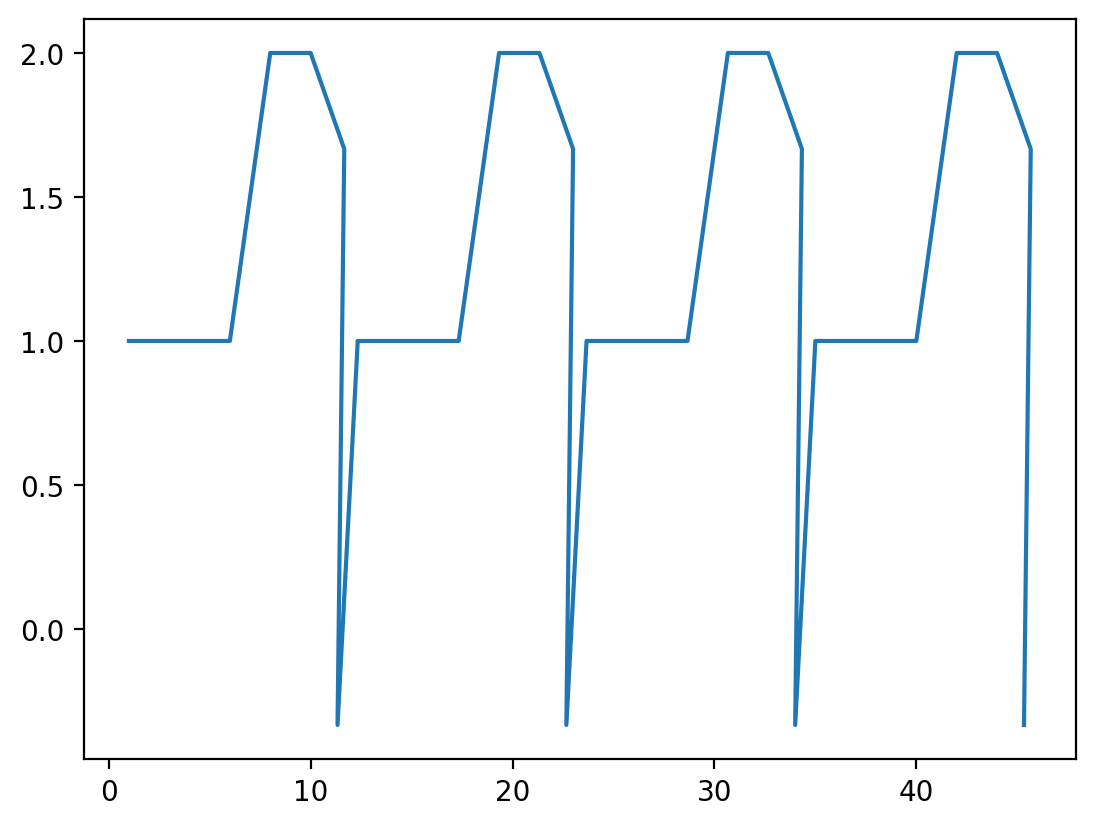

In [34]:
plt.plot(np.cumsum(melody.durations_array),melody.durations_array)

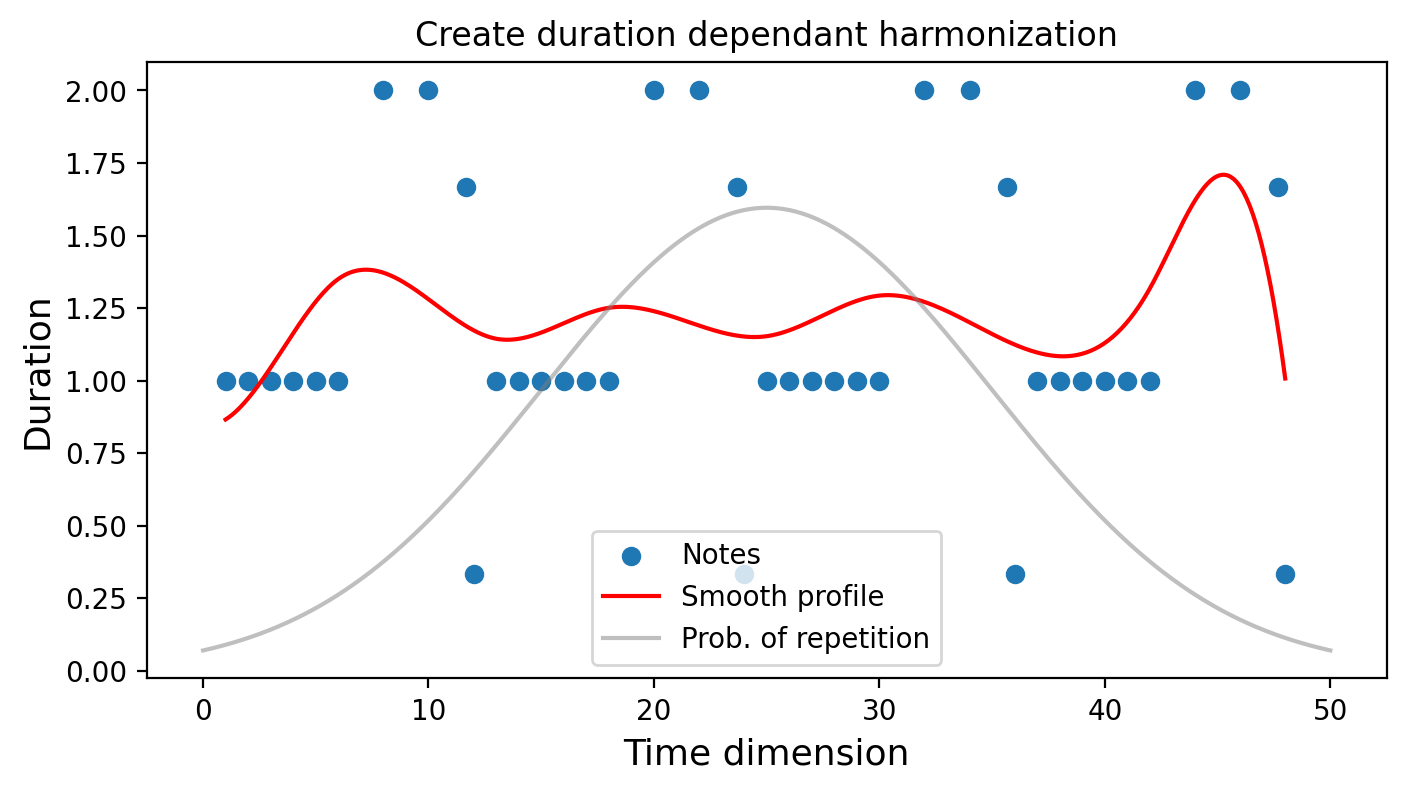

In [378]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

x,y=np.cumsum(np.abs(melody.durations_array)),melody.durations_array

# Crear un spline suave
# s es el parámetro de suavizado. Un valor más alto resulta en una curva más suave.
spline = UnivariateSpline(x, y, s=melody.number_of_bars//3)

# Generar puntos para la curva ajustada
x_smooth = np.linspace(x.min(), x.max(), melody.number_of_bars*30)
y_smooth = spline(x_smooth)

# Código para graficar (opcional, útil para visualizar el ajuste)
plt.figure(figsize=(8, 4))
plt.scatter(x, y, label='Notes')
plt.plot(x_smooth, y_smooth, label='Smooth profile', color='red')
x2=np.linspace(0,50,3000)
gaus_aux=gaussian(x2,25,10)*40

plt.plot(x2,gaus_aux,"grey",label='Prob. of repetition',alpha=0.5)
plt.legend()
plt.xlabel('Time dimension',fontsize=13)
plt.ylabel('Duration',fontsize=13)
plt.title('Create duration dependant harmonization')
plt.show()

# El código proporciona el ajuste de spline. La visualización es opcional pero útil.



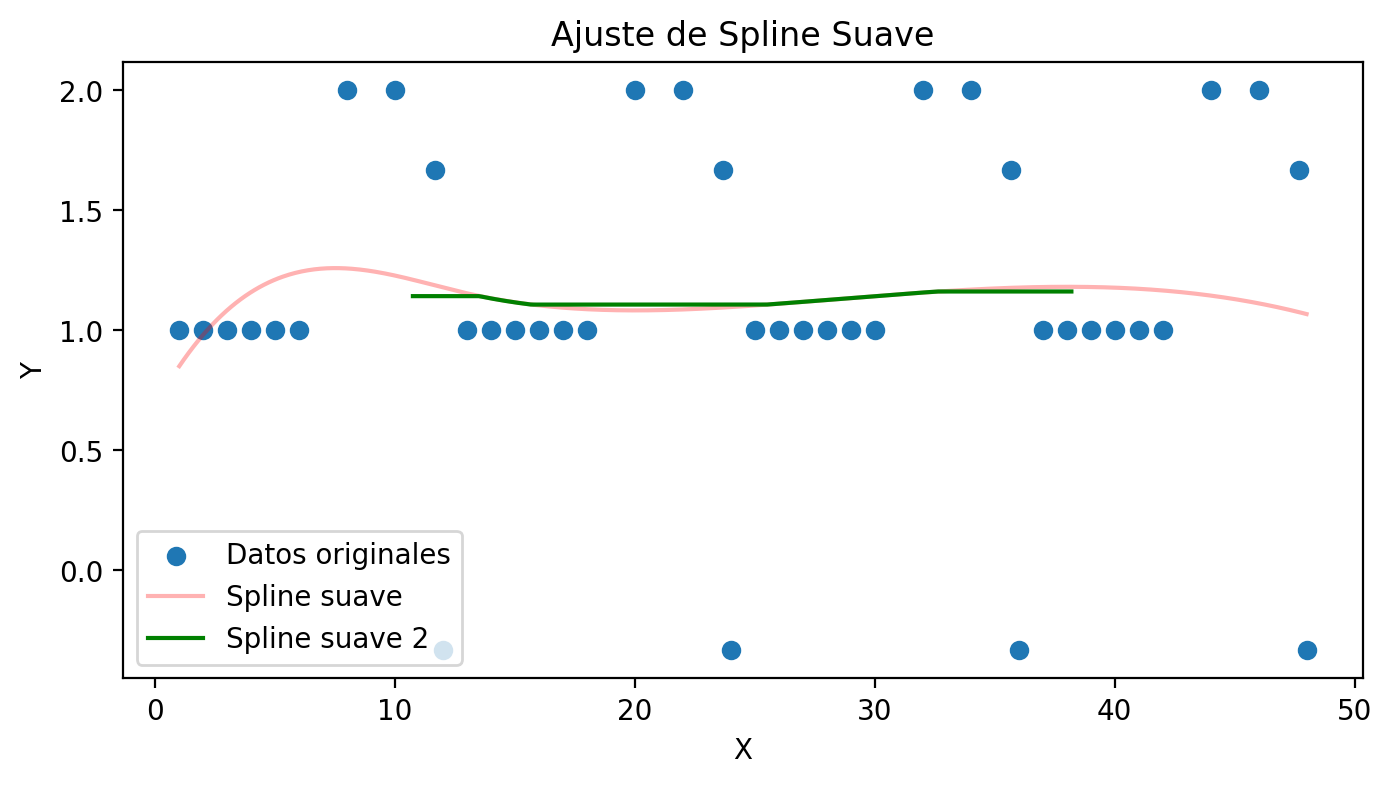

In [142]:
import numpy as np

def mediana_movil(arr, ventana):
    # La longitud de la mediana móvil será menor que la del array original
    # debido a los bordes donde la ventana no se ajusta completamente.
    num_elementos = len(arr) - ventana + 1
    mediana_movil = np.zeros(num_elementos)

    for i in range(num_elementos):
        mediana_movil[i] = np.median(arr[i:i+ventana])

    return mediana_movil

# Ejemplo de uso
ventana = 300  # Tamaño de la ventana para la mediana móvil

resultado = mediana_movil(y_smooth, ventana)
plt.figure(figsize=(8, 4))
plt.scatter(x, y, label='Datos originales')
plt.plot(x_smooth, y_smooth, label='Spline suave', color='red',alpha=0.3)
plt.plot(x_smooth[(x_smooth.size-resultado.size)//2:-(x_smooth.size-resultado.size)//2], resultado, label='Spline suave 2 ', color='green')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ajuste de Spline Suave')
plt.show()

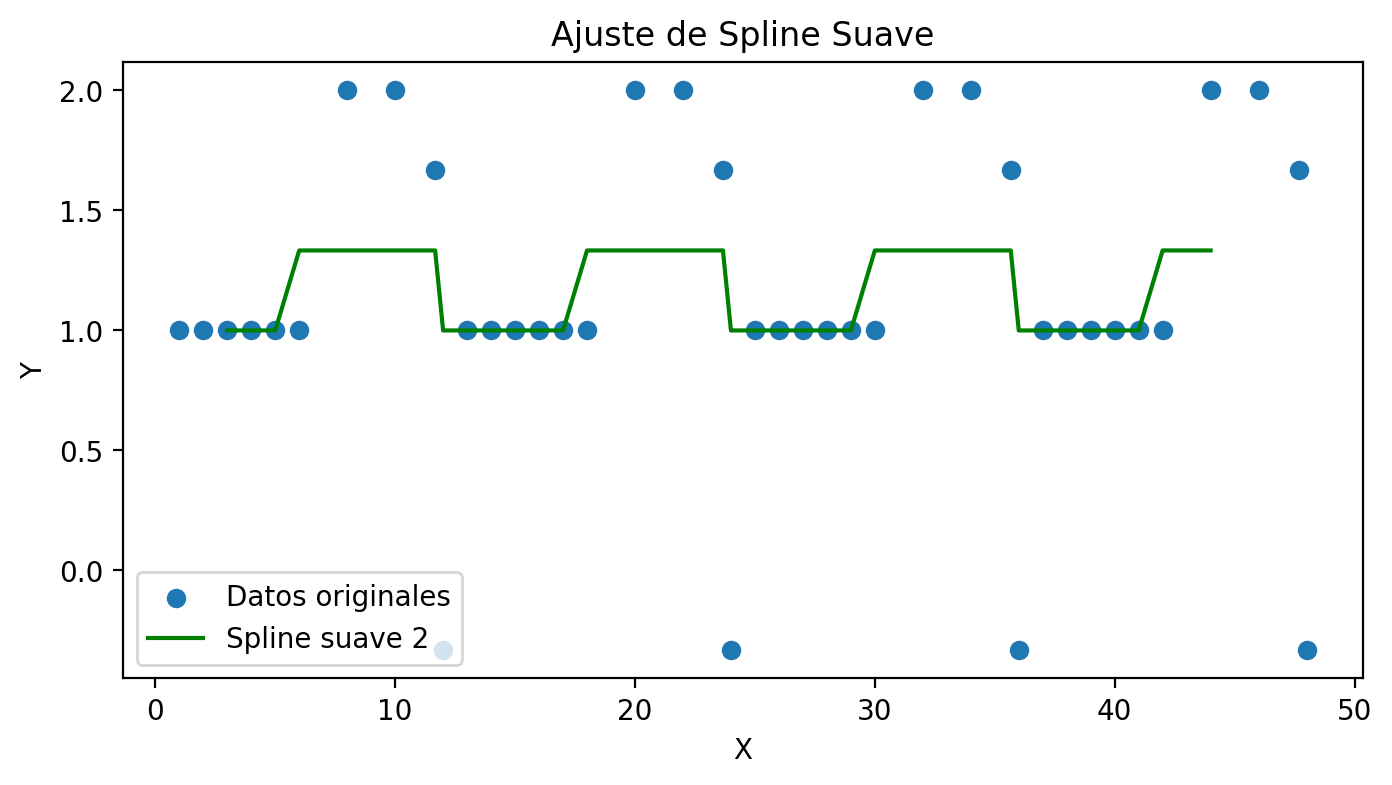

In [150]:
import numpy as np

def mediana_movil(arr, ventana):
    # La longitud de la mediana móvil será menor que la del array original
    # debido a los bordes donde la ventana no se ajusta completamente.
    num_elementos = len(arr) - ventana + 1
    mediana_movil = np.zeros(num_elementos)

    for i in range(num_elementos):
        mediana_movil[i] = np.median(arr[i:(i+ventana)])

    return mediana_movil

# Ejemplo de uso
ventana = 6  # Tamaño de la ventana para la mediana móvil

resultado = mediana_movil(y, ventana)
plt.figure(figsize=(8, 4))
plt.scatter(x, y, label='Datos originales')
plt.plot(x[(x.size-resultado.size)//2:-(x.size-resultado.size)//2], resultado, label='Spline suave 2 ', color='green')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ajuste de Spline Suave')
plt.show()

In [136]:
data_aux=np.stack([x[(x.size-resultado.size)//2:-(x.size-resultado.size)//2],resultado],axis=1)
data_aux

array([[ 3.        ,  0.        ],
       [ 4.        ,  0.        ],
       [ 5.        ,  0.        ],
       [ 6.        ,  6.        ],
       [ 8.        ,  7.        ],
       [10.        ,  8.        ],
       [11.66666667,  8.66666667],
       [12.        ,  7.33333333],
       [13.        ,  7.33333333],
       [14.        ,  7.33333333],
       [15.        ,  6.33333333],
       [16.        ,  5.33333333],
       [17.        ,  4.66666667],
       [18.        ,  6.        ],
       [20.        ,  7.        ],
       [22.        ,  8.        ],
       [23.66666667,  8.66666667],
       [24.        ,  7.33333333],
       [25.        ,  7.33333333],
       [26.        ,  7.33333333],
       [27.        ,  6.33333333],
       [28.        ,  5.33333333],
       [29.        ,  4.66666667],
       [30.        ,  6.        ],
       [32.        ,  7.        ],
       [34.        ,  8.        ],
       [35.66666667,  8.66666667],
       [36.        ,  7.33333333],
       [37.        ,

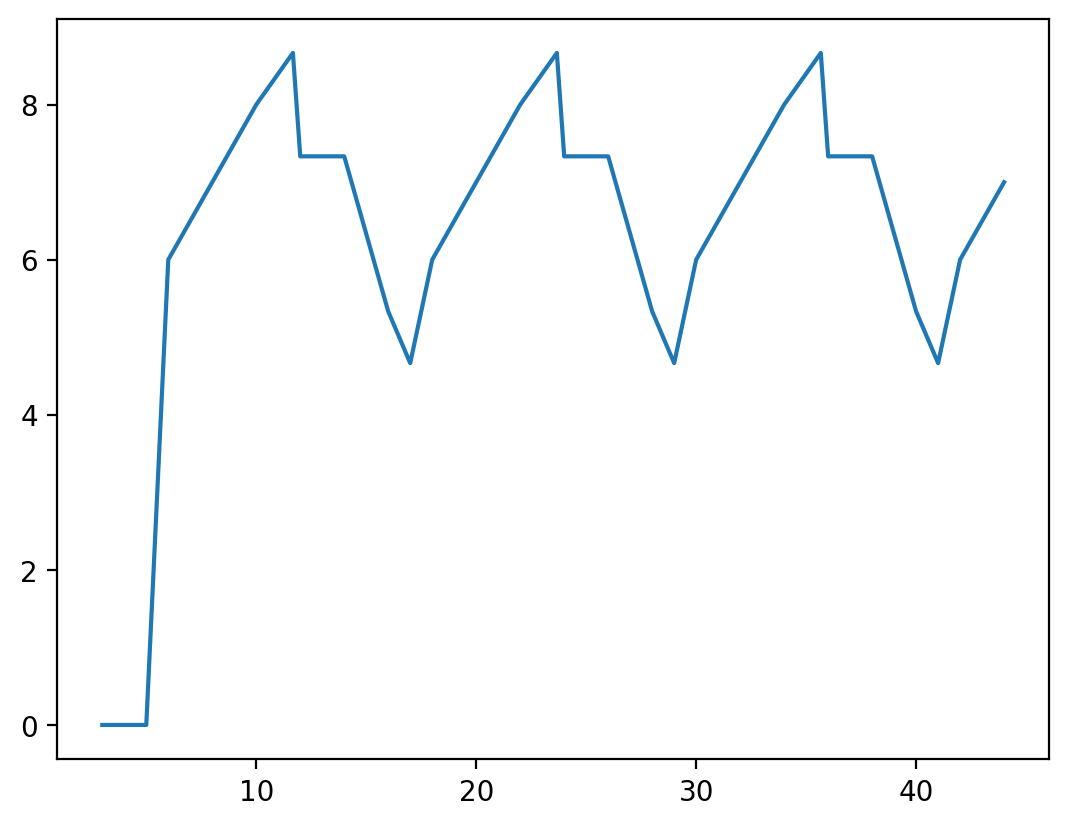

In [139]:
plt.plot(data_aux[:,0],data_aux[:,1])


In [110]:
# escala_cromatica = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"] 
# # Supongamos que quieres encontrar el índice de "G#"
# nota_buscada = melody.key.tonicPitchNameWithCase
# indice = escala_cromatica.index(nota_buscada)


0

In [30]:
aux.flat.getElementsByClass(music21.key.KeySignature)[0].asKey()


<music21.key.Key of A major>

In [27]:
aux=music21.converter.parse('./data-MIDI/carmen_flue.musicxml')
aux.show("text")

{0.0} <music21.metadata.Metadata object at 0x7f86e35bed60>
{0.0} <music21.stream.Part Flute, Fl�te>
    {0.0} <music21.instrument.Flute 'P1: Flute, Fl�te: Flute'>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.tempo.MetronomeMark Quarter=116.0>
        {0.0} <music21.key.KeySignature of 3 sharps>
        {0.0} <music21.meter.TimeSignature 2/4>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note A>
        {0.75} <music21.note.Note A>
        {1.0} <music21.note.Note A>
        {1.25} <music21.note.Note E>
        {1.5} <music21.note.Note D>
        {1.75} <music21.note.Note E>
    {0.0} <music21.spanner.MultiMeasureRest 23 measures>
    {2.0} <music21.stream.Measure 2 offset=2.0>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note A>
        {0.75} <music21.note.Note A>
        {1.0} <music21.note.Note A>
        {1.25} <music21.note.Note B>
        {1.5} <music21.note.Note C#>
        {1.

In [ ]:
aux

In [60]:
parts = []
for part in aux.parts:
       parts.append(part.flat) #or just parts.append(part), as you wish.

In [61]:
notas_convertidas = []

for n in parts[0]:
    aux1=midi_note_to_name_dur(n)

    if aux1 is not None:
        notas_convertidas.append(aux1)

error con Piano: Piano
error con <music21.clef.TrebleClef>
error con <music21.tempo.MetronomeMark animato Quarter=120.0>
error con C major
error con <music21.meter.TimeSignature 2/4>
error con <music21.bar.Barline type=final>


---   
# Gen

In [7]:
weights = {
    "chord_melody_congruence": 0.6,
    "chord_variety": 0.2,
    "harmonic_flow": 0.12,
    "functional_harmony": 0.08
}

# DoubleBass (primera nota y octava 3) , Chello (primera nota y octava 3) , Viola (Tercera nota y octava 4 ) , Violin (segunda nota en octava 5)
chord_mappings = {
    "I": [0,4,7],
    "ii": [2,5,9],
    "iii": [4,7,11],
    "IV": [5,9,0],
    "V": [7,11,2],
    "vi": [9, 0, 4],
    "vii-dim": [11, 2, 5]
}

# preferred_transitions = {
#     "I": ["V", "VI", "IV"],
#     "ii": ["G", "Am"],
#     "Em": ["Am", "F", "C"],
#     "F": ["C", "G"],
#     "G": ["Am", "C"],
#     "Am": ["Dm", "Em", "F", "C"],
#     "Bdim": ["F", "Am"]
# }

preferred_transitions = {
    "I": ["V", "vi", "IV"],
    "ii": ["V", "vi"],
    "iii": ["vi", "F", "C"],
    "IV": ["I", "V","ii","iii"],
    "V": ["vi", "I","IV"],
    "vi": ["ii", "iii", "IV"],
    "vii-dim": ["I"]
}

In [339]:
chromatic_scale = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"] 

len_escala=len(escala_cromatica)
pos_0=6 # key A --> 6 
new_escala=escala_cromatica[pos_0:]+escala_cromatica[:pos_0]
index=[0,3,7]
print(new_escala)
print([new_escala[i] for i in index])
print([escala_cromatica[(i+pos_0)%len_escala] for i in index])
# 0 , 4 y 7  #Escala mayor
# M-- 0,4,7
# m-- 0,3,7
# dim-- 0,3,6

# I-- M desde el 0 
# II--m desde el 2
# III-- m desde el 4
# IV -- M desde el 5
# V-- M desde el 7 
# VI--m desde el 9
# VII-- dim desde el 11

mapeo_bemoles = {
    "Db": "C#",
    "Eb": "D#",
    "Fb": "E",  # Fb es en realidad E
    "Gb": "F#",
    "Ab": "G#",
    "Bb": "A#",
    "Cb": "B"   # Cb es en realidad B
}

escala_cromatica_completa = ["C", "C#","Db", "D", "D#","Eb","E", "F", "F#","Gb", "G","G#","Ab", "A", "A#","Bb", "B"]






['F#', 'G', 'G#', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F']
['F#', 'A', 'C#']
['F#', 'A', 'C#']


In [17]:
melody=MelodyData(file_path="./data-MIDI/carmen_flue.musicxml",)


IndexError: list index out of range

In [13]:
fitness_evaluator = FitnessEvaluator(
    melody_data=melody,
    weights=weights,
    preferred_transitions=preferred_transitions,
)


In [14]:
harmonizer = GeneticMelodyHarmonizer(
    melody_data=melody,
    population_size=int(500),
    mutation_rate=0.1,
    fitness_evaluator=fitness_evaluator,
)

In [15]:
# Generate chords with genetic algorithm
generated_chords = harmonizer.generate(generations=300)


In [286]:
# def create_score(melody, chord_sequence, chord_mappings,mapping):
#     #mapping={"Melodia":"Flute","Bajo1":"DoubleBass","Bajo2":"Chello","Tenor":"Viola","Alto":"Violin2","Soprano":"Violin1"}
#     score = music21.stream.Score()
#     duration_per_section=2
    
#     # Create the melody part and add notes to it
#     melody_part = music21.stream.Part()
#     melody_part.append(mapping["Melodia"])
#     melody_part.append(music21.tempo.MetronomeMark(number=120))
#     melody_part.append( music21.meter.TimeSignature('2/4'))

#     for note_name, duration in melody.notes:
#         if not isinstance(note_name,list):
#             if note_name == "Rest":
#                 melody_note = music21.note.Rest(quarterLength=duration)
#             else:    
#                 melody_note = music21.note.Note(note_name, quarterLength=duration)
#         else:
#             melody_note = music21.chord.Chord(note_name, quarterLength=duration)
#         melody_part.append(melody_note)

#     # ================================================================


#     # 5 partes para el acompañamiento

#     # primera BAJO 

#     bajo1_part = music21.stream.Part()

#     current_duration = 0  # Track the duration for chord placement
#     bajo1_part.append(mapping["Bajo1"])
#     bajo1_part.append(music21.tempo.MetronomeMark(number=120))
#     bajo1_part.append(music21.meter.TimeSignature('2/4'))
    
#     for chord_name in chord_sequence:
#         # Translate chord names to note lists
#         chord_notes_list = chord_mappings.get(chord_name, [])[0]
#         # Create a music21 chord
#         chord_notes = music21.chord.Chord([music21.note.Note(chord_notes_list,octave=3)], quarterLength=2)  # Assuming 2/4 time signature
#         chord_notes.offset = current_duration
#         bajo1_part.append(chord_notes)
#         current_duration += duration_per_section  # Increase by 4 beats
    
#     # segunda Bajo 

#     bajo2_part = music21.stream.Part()

#     current_duration = 0  # Track the duration for chord placement
#     bajo2_part.append(mapping["Bajo2"])
#     bajo2_part.append(music21.tempo.MetronomeMark(number=120))
#     bajo2_part.append(music21.meter.TimeSignature('2/4'))
    
#     for chord_name in chord_sequence:
#         # Translate chord names to note lists
#         chord_notes_list = chord_mappings.get(chord_name, [])[0]
#         # Create a music21 chord
#         chord_notes = music21.chord.Chord([music21.note.Note(chord_notes_list,octave=3)], quarterLength=2)  # Assuming 2/4 time signature
#         chord_notes.offset = current_duration
#         bajo2_part.append(chord_notes)
#         current_duration += duration_per_section  # Increase by 4 beats
    

#     #tercero, Tenor

#     tenor_part = music21.stream.Part()

#     current_duration = 0  # Track the duration for chord placement
#     tenor_part.append(mapping["Tenor"])
#     tenor_part.append(music21.tempo.MetronomeMark(number=120))
#     tenor_part.append(music21.meter.TimeSignature('2/4'))
    
#     for chord_name in chord_sequence:
#         # Translate chord names to note lists
#         chord_notes_list = chord_mappings.get(chord_name, [])[2]
#         # Create a music21 chord
#         chord_notes = music21.chord.Chord([music21.note.Note(chord_notes_list,octave=4)], quarterLength=2)  # Assuming 2/4 time signature
#         chord_notes.offset = current_duration
#         tenor_part.append(chord_notes)
#         current_duration += duration_per_section  # Increase by 4 beats

#     #tercero, Alto (violin2)

#     alto_part = music21.stream.Part()

#     current_duration = 0  # Track the duration for chord placement
#     alto_part.append(mapping["Alto"])
#     alto_part.append(music21.tempo.MetronomeMark(number=120))
#     alto_part.append(music21.meter.TimeSignature('2/4'))
    
#     for chord_name in chord_sequence:
#         # Translate chord names to note lists
#         chord_notes_list = chord_mappings.get(chord_name, [])[1]
#         # Create a music21 chord
#         chord_notes = music21.chord.Chord([music21.note.Note(chord_notes_list,octave=5)], quarterLength=2)  # Assuming 2/4 time signature
#         chord_notes.offset = current_duration
#         alto_part.append(chord_notes)
#         current_duration += duration_per_section  # Increase by 4 beats


#     #tercero, Soprano (violin1)

#     # soprano_part = music21.stream.Part()

#     # current_duration = 0  # Track the duration for chord placement
#     # soprano_part.append(mapping["Soprano"])
#     # soprano_part.append(music21.tempo.MetronomeMark(number=120))
#     # soprano_part.append(music21.meter.TimeSignature('2/4'))
    
#     # for chord_name in chord_sequence:
#     #     # Translate chord names to note lists
#     #     chord_notes_list = chord_mappings.get(chord_name, [])[2]
#     #     # Create a music21 chord
#     #     chord_notes = music21.chord.Chord([music21.note.Note(chord_notes_list,octave=4)], quarterLength=2)  # Assuming 2/4 time signature
#     #     chord_notes.offset = current_duration
#     #     soprano_part.append(chord_notes)
#     #     current_duration += duration_per_section  # Increase by 4 beats


#     # Create the melody part and add notes to it
#     soprano_part = music21.stream.Part()
#     soprano_part.append(mapping["Soprano"])
#     soprano_part.append(music21.tempo.MetronomeMark(number=120))
#     soprano_part.append( music21.meter.TimeSignature('2/4'))

#     for note_name, duration in melody.notes:
#         if not isinstance(note_name,list):
#             if note_name == "Rest":
#                 melody_note = music21.note.Rest(quarterLength=duration)
#             else:    
#                 melody_note = music21.note.Note(note_name, quarterLength=duration)
#         else:
#             melody_note = music21.chord.Chord(note_name, quarterLength=duration)
#         soprano_part.append(melody_note)


#     # Append parts to the score
#     score.append(melody_part)
#     score.append(bajo1_part)
#     score.append(bajo2_part)
#     score.append(tenor_part)
#     score.append(alto_part)
#     score.append(soprano_part)

#     return score

In [122]:
mapping={"Melodia":music21.instrument.Flute(),"Bajo1":music21.instrument.Contrabass(),"Bajo2":music21.instrument.Violoncello(),"Tenor":music21.instrument.Viola(),"Alto":music21.instrument.Violin(),"Soprano":music21.instrument.Violin()}


In [123]:
# # Render to music21 score and show it
# music21_score = create_score(
#     melody, generated_chords, chord_mappings,mapping
# )

---   

In [384]:
# cuerda
conf_harm_cuerda={"Channel_1":{"name": "Flute_Melody" , "instrument":music21.instrument.Flute(),"level":"Melody" , "octave":None,"repetition":True },
           "Channel_2":{"name": "Soprano" , "instrument":music21.instrument.Violin(),"level":"Melody" , "octave":5 ,"repetition":True},
           "Channel_3":{"name": "Alto" , "instrument":music21.instrument.Violin(),"level":[1] , "octave": 5 ,"repetition":True},
           "Channel_4":{"name": "Tenor" , "instrument":music21.instrument.Viola(),"level":[2] , "octave": 4 ,"repetition":True},
           "Channel_5":{"name": "Chello" , "instrument":music21.instrument.Violoncello(),"level":[0] , "octave":3 ,"repetition":False},
           "Channel_6":{"name": "DoubleBass" , "instrument":music21.instrument.Contrabass(),"level":[0] , "octave":3 ,"repetition":False}
           }

# viento metal
conf_harm_viento_metal={"Channel_7":{"name": "Tuba" , "instrument":music21.instrument.Tuba(),"level":[0] , "octave":3 ,"repetition":True},
           "Channel_8":{"name": "Trombone" , "instrument":music21.instrument.Trombone(),"level":[2] , "octave":3 ,"repetition":False},
           "Channel_9":{"name": "FrenchHorn" , "instrument":music21.instrument.Horn(),"level":[1] , "octave": 5 ,"repetition":False}
           }


# viento madera
conf_harm_viento_madera={"Channel_10":{"name": "Fagot" , "instrument":music21.instrument.EnglishHorn(),"level":[0] , "octave":3 ,"repetition":False},
           "Channel_11":{"name": "Clarinet" , "instrument":music21.instrument.Clarinet(),"level":[2] , "octave":3 ,"repetition":True},
           "Channel_12":{"name": "Flute" , "instrument":music21.instrument.Flute(),"level":[1] , "octave": 4 ,"repetition":True}
           }

In [363]:
def create_score2(melody, chord_sequence, conf_harm):
    chord_mappings=melody.chord_mappings
    indices_alegro=melody.positions_allegro
    score = music21.stream.Score()
    duration_per_section = melody.time_signature.numerator
    number_notes_in_fast_measures=2
    small_duration_per_section=duration_per_section/number_notes_in_fast_measures
    score.append(melody.tempo)
    for channel, config in conf_harm.items():
        part = music21.stream.Part()
        part.append(config["instrument"])
        part.append(copy.deepcopy(melody.time_signature))


        if config["level"] == "Melody":
            for note_name, duration,octave in melody.notes:
                if config["octave"] is not None:
                    octave=config["octave"]
                if not isinstance(note_name, list):
                    if note_name == "Rest":
                        music_note = music21.note.Rest(quarterLength=duration)
                    else:
                        music_note = music21.note.Note(note_name, 
                                                       quarterLength=duration, 
                                                       octave=octave)
                else:
                    music_note = music21.chord.Chord(note_name, 
                                                     quarterLength=duration, 
                                                     octave=octave)
                part.append(music_note)
        else:
            current_duration = 0
            for i,chord_name in enumerate(chord_sequence):
                if (any([j in melody.note_measure_correspondance[i] for j in melody.positions_allegro]))&(config["repetition"]):
                    for _ in range(number_notes_in_fast_measures):
                        chord_notes_list = [chord_mappings.get(chord_name, [])[i] for i in config["level"]]
                        chord_notes = music21.chord.Chord([music21.note.Note(i, octave=config["octave"]) for i in chord_notes_list], 
                                                        quarterLength=small_duration_per_section)
                        chord_notes.offset = current_duration
                        part.append(chord_notes)
                        current_duration += small_duration_per_section
                else:
                    chord_notes_list = [chord_mappings.get(chord_name, [])[i] for i in config["level"]]
                    chord_notes = music21.chord.Chord([music21.note.Note(i, octave=config["octave"]) for i in chord_notes_list], 
                                                    quarterLength=duration_per_section)
                    chord_notes.offset = current_duration
                    part.append(chord_notes)
                    current_duration += duration_per_section

        score.append(part)

    return score


In [364]:
melody.positions_allegro

[5, 12, 14, 15, 19, 21, 22, 25]

In [365]:
# Render to music21 score and show it
conf_harm_cuerda.update(conf_harm_viento_madera)
conf_harm_cuerda.update(conf_harm_viento_metal)
music21_score = create_score2(melody, generated_chords,conf_harm_cuerda)

In [366]:
music21_score.write('midi', fp='pablo_6.mid')


'pablo_6.mid'

In [368]:
print(generated_chords)

['I', 'vi', 'iii', 'vi', 'vi', 'IV', 'ii', 'ii', 'vii-dim', 'vi', 'vi', 'iii', 'I', 'I', 'IV', 'IV', 'vi', 'ii', 'V', 'I', 'V', 'IV', 'I', 'I']
